## Find Pattern
#### Pseudocode
```python
        if (19년 데이터 + 20년 1월) 전부 존재:
            (19년 데이터 + 20년 1월)만 가지고 std를 계산
            if std > 0.3: # error_group
                if p < 0.5:  ## 변동성이 적다.
                     cov_ratio = (20Y03M/20Y02M) / (19Y03M/19Y02M)

                    if 변화가 선형적이다: .........1)
                        예측7월 <- 올해4월 * cov_ratio
                        올해4월 <- 올해 3월 * cov_ratio

                    else 변화가 비선형적이다:
                        if 계절성을 갖는다.: .........2)
                            # 다항회귀 모델 예측후 rmse 가 0.25보다 작고, diff_per가 25%미만일 경우
                            예측7월 <- 작년 7월 * cov_ratio
                            예측4월 <- 작년 4월 * cov_ratio

                        elif 특별한 규칙이 없다: .........3)
                            # 다항회귀 모델 예측후 rmse 가 0.25보다 크거나 같고, diff_per가 25% 이상일 경우
                            cov_ratio = (20Y03M + 20Y02M) / (19Y03M + 19Y02M)
                            # 특별한 규칙이 없는 경우는 19년 2,3월과
                            # 20년 2,3월의 스케일만을 비교하는 것이 더 효율적이다.
                            예측7월 <- 전체 평균을 사용 * cov_ratio
                            예측4월 <- 전체 평균을 사용 * cov_ratio

                elif p >= 0.5:  ## 변동성이 크다.
                    cov_ratio = (20Y03M/20Y02M) / (19Y03M/19Y02M)

                    if 변화가 선형적이다: .........4)
                        예측7월 <- 올해4월  * cov_ratio

                    else 변화가 비선형적이다:
                        if 계절성을 갖는다.: .........5)
                            # (다항회귀 모델 예측후 rmse 가 0.45보다 작다) and (diff_per가 30%미만이다)
                            예측7월 <- 작년 6월 ~ 8월 평균* cov_ratio
                            예측4월 <- 작년 2월 ~ 3월 평균* cov_ratio

                        elif 특별한 규칙이 없다: .........6)
                            # (다항회귀 모델 예측후 rmse 가 0.45보다 크다) or (diff_per가 30% 이상이다)
                            예측7월 <- 전체 평균을 사용* cov_ratio
                            예측4월 <- 전체 평균을 사용* cov_ratio

            else std <= 0.3:
                전체 평균 * cov_ratio .........7)
                
        else 19년 데이터가 전부 존재하지 않는다: # uncomplete_group
```

## Library import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import numpy as np
from matplotlib import font_manager, rc
from tqdm import tqdm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

path = '../data/'
data = pd.read_csv(path +'201901-202003.csv')
new_data = pd.read_csv(path + '202004.csv')
gc.collect()
data = pd.concat([data, new_data], axis = 0)

In [2]:
#----------------------------------------------
## <group_city_clss_time>
# 데이터를 날짜, 도시, 업종으로 groupby
# 인덱싱을 편하게 하기 위해 row를 CARD_SIDO_NM,	STD_CLSS_NM, REG_YYMM 3개의 level로 표현
group_city_clss_time = data.loc[:, ['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]\
                           .groupby(['CARD_SIDO_NM', 'STD_CLSS_NM', 'REG_YYMM'])['AMT']\
                           .sum()
group_city_clss_time = pd.DataFrame(group_city_clss_time)
gc.collect()
#group_data는 'AMT'하나만 column으로 갖는다.
#group_city_clss_time = np.log(group_city_clss_time)
#print('group_city_clss_time')
#display(group_city_clss_time)
#----------------------------------------------
## <group_data>
group_data = np.log(group_city_clss_time)
#print('group_data')
#display(group_data)
#----------------------------------------------
## <group_city_clss_time_count>
group_city_clss_time_count = data.loc[:, ['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]\
                           .groupby(['CARD_SIDO_NM', 'STD_CLSS_NM', 'REG_YYMM'])['AMT']\
                           .count()
group_city_clss_time_count = pd.DataFrame(group_city_clss_time_count)
group_city_clss_time_count.columns = ['COUNT']
#print('group_city_clss_time_count')
#display(group_city_clss_time_count)
#----------------------------------------------
## <group_city_clss>
data['sido_clss_rows_under'] = (data.CSTMR_CNT <= 3) * 1
group_city_clss = pd.DataFrame(data.loc[:, ['CARD_SIDO_NM', 'STD_CLSS_NM', 'sido_clss_rows_under']].\
                               groupby(['CARD_SIDO_NM', 'STD_CLSS_NM'])[['sido_clss_rows_under']].sum())
group_city_clss['total_rows'] = data.loc[:, ['CARD_SIDO_NM', 'STD_CLSS_NM', 'sido_clss_rows_under']].\
                               groupby(['CARD_SIDO_NM', 'STD_CLSS_NM'])[['sido_clss_rows_under']].count()
group_city_clss['p'] = group_city_clss.sido_clss_rows_under / group_city_clss.total_rows
group_city_clss['std_error'] = -1.
group_city_clss['diff_per'] = -1.
group_city_clss['rmse'] = -1.
group_city_clss['r2_rate'] = -1.
group_city_clss

#print('group_city_clss')
#display(group_city_clss)
gc.collect()

group_city_clss


13

### Make Plot Function

In [3]:
def cal_std_p(group_city_clss, std_th):
    days = group_data.reset_index()['REG_YYMM'].unique().astype('str') # REG_YYMM를 string으로 변환
    citys = data.CARD_SIDO_NM.unique() # citys : 지역(시도)의 이름들을 list로 저장
    error_group = [] # std가 0.3이상인 그룹 저장
    uncomplete_group = [] # 모든 월별 데이터가 없는 그룹 저장

    for city in tqdm(citys):
        clsses = data[data.CARD_SIDO_NM == city].STD_CLSS_NM.unique()
        # 특정지역에서는 업종이 없는 경우도 있음.
        # 지역별로 업종 list를 새로 생성
        for clss in clsses:
            y = group_data.loc[city, clss,:].values.reshape(-1)
            if len(y) == len(days):
                x = np.arange(12).reshape(-1,1)
                y_pred = np.zeros(12)
                y_pred[:] = y[:12].mean()
                std = y[:12].std()
                group_city_clss.loc[(city, clss),'std_error'] = std
                if std_th < std:
                    error_group.append((city, clss))
                else: 
                    pass
            else:
                uncomplete_group.append((city, clss))
                group_city_clss.loc[(city, clss),'std_error'] = -1
    #del group_data
    gc.collect()
    group_city_clss
    return error_group, uncomplete_group, group_city_clss

def plot_groups_by_month(group_list, log = True, figsize = (15,30)):
    plt.figure(figsize = figsize)
    for index in range(len(group_list)):
        all_month = ['201901', '201902', '201903', '201904', '201905', '201906', '201907',
                 '201908', '201909', '201910', '201911', '201912', '202001', '202002', '202003', '202004']
        new_y = {}
        city, clss = group_list[index]
        for month in all_month:
            if month in list(map(str, group_city_clss_time.loc[city, clss].index)):
                new_y[month] = int(group_city_clss_time.loc[city, clss, int(month)])
            else:
                new_y[month] = 0
                
        new_y = list(new_y.values())
        if log == True:
            new_y = np.log(new_y)
            
        plt.plot(all_month, new_y, 'o-', label = group_list[index])
        plt.legend(bbox_to_anchor=(1.0, 1.0), fontsize = 15)
        #plt.title(group_list[index][0])
        plt.xticks(rotation = 45, fontsize = 15)
    plt.show()
    
def plot_city_clss_by_month(city, clss, color = 'red', count_ratio = 1):
    all_month = ['201901', '201902', '201903', '201904', '201905', '201906', '201907',
                 '201908', '201909', '201910', '201911', '201912', '202001', '202002', '202003', '202004']
    new_amt = {}
    new_count = {}
    mean_amt = group_city_clss_time.loc[city, clss].mean()
    
    if len(group_city_clss_time.loc[city, clss].index) != len(all_month):
        print('<AMT가 0인 년월>')
        
    zero_month = []
    for month in all_month:
        if month in list(map(str, group_city_clss_time.loc[city, clss].index)):
            new_amt[month] = int(group_city_clss_time.loc[city, clss, int(month)])
            new_count[month] = int(group_city_clss_time_count.loc[city, clss, int(month)]) * mean_amt/10 * count_ratio
        else:
            new_amt[month] = 0
            new_count[month] = 0
            zero_month.append(month)
    print(zero_month)
    plt.plot(all_month, list(new_amt.values()), 'o-', color = color, label = 'AMT')
    plt.plot(all_month, list(new_count.values()), 'o-', label  = 'COUNT')
    plt.legend()
    plt.title(city + ' ' + clss)
    plt.xticks(rotation = 45)
    plt.show()
    
def plot_multi_group(group_list, figsize = (10,5), log = True):
    # 10개씩 끊어서 시각화 하는 함수
    for i in range(len(group_list)//10 + 1):
        if i == len(group_list)//10:
            plot_groups_by_month(group_list[(i)*10:], figsize = figsize, log = log)
        else:
            plot_groups_by_month(group_list[i*10:(i+1)*10], figsize = figsize, log = log)
def plot_linear_reg(group_list, r2_rate, plot = True):
    group_linear = []
    group_unlinear = []
    for i in range(len(group_list)):
        city, clss = group_list[i][0], group_list[i][1]
        y = np.array(group_city_clss_time.loc[city, clss].AMT)
        y = np.log(y)
        x = np.arange(13).reshape(-1, 1)
        lin_reg = LinearRegression()
        lin_reg.fit(x, y[:13])
        y_predict = lin_reg.predict(x)
        r2 = r2_score(y[:13], y_predict)
        #**group_city_clss에 접근하여 r2를 저장**##
        group_city_clss.loc[(city, clss), 'r2_rate'] = r2
        #** ---- **#
        if r2 > r2_rate:
            group_linear.append((city, clss))
        else:
            group_unlinear.append((city, clss))

        if plot:
            if r2 > r2_rate:
                plt.plot(x, y[:13], 'o-')
                plt.plot(x, y_predict, 'o-')
                plt.show()
                print(city,' ', clss)
                print('r2 score', r2)
        else:
            pass
    #return group_linear, group_unlinear
    
def plot_poly_reg(group, plot = True):
    city, clss = group[0], group[1]
    poly_features = PolynomialFeatures(degree = 4, include_bias=False)
    y = np.array(group_city_clss_time.loc[city, clss].AMT)
    y = np.log(y)
    x = np.arange(13)
    x_poly = poly_features.fit_transform(x.reshape(-1,1))
    lin_reg = LinearRegression()
    lin_reg.fit(x_poly,  y[:13])
    y_predict = lin_reg.predict(x_poly)
    
    diff_min_max = max(y[:13]) - min(y[:13])
    diff_start_end = abs(y_predict[0] - y_predict[-1])
    diff_per = diff_start_end / diff_min_max * 100
    rmse = np.sqrt(np.mean((y_predict - y[:13])**2))
    
    
    if plot:
        plt.plot(x, y[:13], 'o-')
        plt.plot(x, y_predict, 'o-')
        plt.show()
        print(city,' ', clss)
        print(diff_per, '%')
        print(rmse)
    else:
        pass

    #print(diff_min_max)
    #print(diff_start_end)

    return diff_per, rmse

def find_diff_rmse(group_list, plot = True):
    diff_per_list  = []
    rmse_list = []
    for i in range(len(group_list)):
        diff_per, rmse = plot_poly_reg(group_list[i], plot = plot)

        group_city_clss.loc[group_list[i], 'diff_per'] = diff_per
        group_city_clss.loc[group_list[i], 'rmse'] = rmse

        diff_per_list.append(diff_per)
        rmse_list.append(rmse)
    return diff_per_list, rmse_list

def plot_diff_rmse(diff_per_list, rmse_list, x1 = 25, x2 = 0.25):
    plt.figure(figsize = (10,5))

    plt.subplot(1,2,1)
    sns.distplot(diff_per_list, bins = 15)
    plt.xlabel('diff_per')
    plt.axvline(x1, c = 'red')

    plt.subplot(1,2,2)
    sns.distplot(rmse_list, bins = 15)
    plt.xlabel('rmse')
    plt.axvline(x2, c = 'red')

    plt.show()
    
def split_group(std_th, p_th, r2_rate_th_1, r2_rate_th_2, diff_th_1, diff_th_2, rmse_th_1, rmse_th_2):
    group_dic = {}
    # set index  std_over_0p3, p_under_0p5
    std_over_0p3 = group_city_clss.std_error > std_th
    p_under_0p5 = group_city_clss.p < p_th
    r2_over_th = group_city_clss.r2_rate > r2_rate_th_1
    diff_under_th = group_city_clss.diff_per < diff_th_1
    rmse_under_th = group_city_clss.rmse < rmse_th_1
    
    # 1) 
    group_dic[1] = group_city_clss.loc[std_over_0p3 & p_under_0p5 & \
                                  r2_over_th].index

    # 2)
    group_dic[2] = group_city_clss.loc[std_over_0p3 & p_under_0p5 & \
                                  ((r2_over_th - 1)*(-1)) & \
                                  diff_under_th & rmse_under_th].index

    # 3)
    group_dic[3] = group_city_clss.loc[std_over_0p3 & p_under_0p5 &\
                                       ((r2_over_th - 1)*(-1)) &\
             (((diff_under_th - 1)*(-1)) | ((rmse_under_th - 1)*(-1)))].index

    # set index std_over_0p3, p_over_0p5
    p_over_0p5 = group_city_clss.p >= p_th
    r2_over_th = group_city_clss.r2_rate > r2_rate_th_2
    diff_under_th = group_city_clss.diff_per < diff_th_2
    rmse_under_th = group_city_clss.rmse < rmse_th_2


    # 4)
    group_dic[4] = group_city_clss.loc[std_over_0p3 & p_over_0p5 &\
                                  r2_over_th].index
    # 5)
    group_dic[5] = group_city_clss.loc[std_over_0p3 & p_over_0p5 &\
                                  ((r2_over_th - 1)*(-1)) & \
                                  diff_under_th & rmse_under_th].index

    # 6)
    group_dic[6] = group_city_clss.loc[std_over_0p3 &p_over_0p5 &\
                                  ((r2_over_th - 1)*(-1)) & \
                    (((diff_under_th - 1)*(-1)) | ((rmse_under_th - 1)*(-1)))].index

    # set index std_under_0p3
    std_under_0p3 = (group_city_clss.std_error <= std_th)&\
                    (group_city_clss.std_error >= 0) 

    # 7)
    group_dic[7] = group_city_clss.loc[std_under_0p3].index

    # 8) set index uncomplete_group
    group_dic[8] = uncomplete_group
    return group_dic

# ----------여기까지는 그냥 한번만 쭈욱 실행---------------------

## group_city_clss 초기화

In [22]:
# group_city_clss 초기화
group_city_clss['std_error'] = -1.
group_city_clss['diff_per'] = -1.
group_city_clss['rmse'] = -1.
group_city_clss['r2_rate'] = -1.

### Threshold 정하기

In [23]:
#*************************
std_th = 0.15
#*************************
error_group, uncomplete_group, group_city_clss = cal_std_p(group_city_clss, std_th = std_th)
print(len(error_group))

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:32<00:00,  1.92s/it]


In [25]:
#*************************
p_th = 0.5
#*************************
over_std_under_pth = list(group_city_clss.loc[((group_city_clss.p < p_th) & (group_city_clss.std_error > std_th))].index)
over_std_over_pth = list(group_city_clss.loc[((group_city_clss.p >= p_th) & (group_city_clss.std_error > std_th))].index)

In [26]:
#************************* p < p_th (변동성 작은 그룹)에서
r2_rate_th_1 = 0.7
#************************* p >= p_th (변동성 큰 그룹)에서
r2_rate_th_2 = 0.5
#*************************
plot_linear_reg(over_std_under_pth, r2_rate = r2_rate_th_1, plot = False)
plot_linear_reg(over_std_over_pth, r2_rate = r2_rate_th_2, plot = False)
under_diff_per_list, under_rmse_list = find_diff_rmse(over_std_under_pth, plot = False)
over_diff_per_list, over_rmse_list = find_diff_rmse(over_std_over_pth, plot = False)

In [27]:
#*************************p < p_th (변동성 작은 그룹)에서
diff_th_1 = 30
rmse_th_1 = 0.3
#*************************p >= p_th (변동성 큰 그룹)에서
diff_th_2 = 30
rmse_th_2 = 0.3
#*************************

## split_group by threshold

In [28]:
#************************* threshold에 의해서 그룹 나누기
group_dic = split_group(std_th, p_th, r2_rate_th_1, r2_rate_th_2, diff_th_1, diff_th_2, rmse_th_1, rmse_th_2)

In [29]:
print('group_city_clss의 길이 : ', len(group_city_clss))
print('\n')
print('그룹별 크기')
total = 0
for i in range(1, 9):
    print('gorup_', i, ' : ', len(group_dic[i]))
    total += len(group_dic[i])
print(f'총합 : {total}')
print('\n')
print('그룹별 크기의 합은 group_city_clss의 길이와 일치한다.')

group_city_clss의 길이 :  650


그룹별 크기
gorup_ 1  :  7
gorup_ 2  :  126
gorup_ 3  :  77
gorup_ 4  :  1
gorup_ 5  :  6
gorup_ 6  :  14
gorup_ 7  :  363
gorup_ 8  :  56
총합 : 650


그룹별 크기의 합은 group_city_clss의 길이와 일치한다.


### plot groups

## group_1

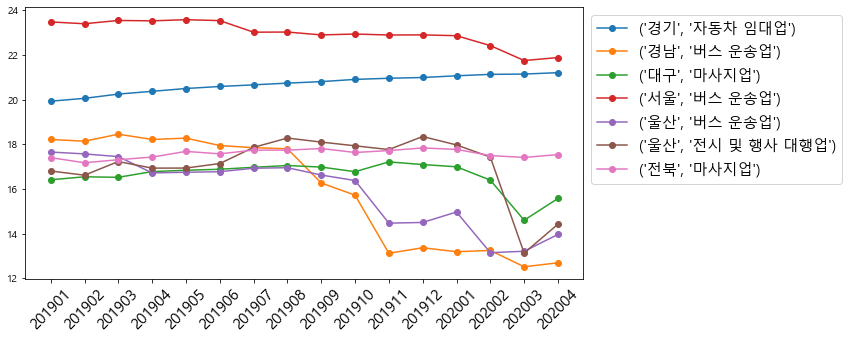

In [11]:
# 변동성이 작으면서 선형성을 갖는 그룹
# std > std_th
# p < p_th
# 선형성
plot_multi_group(group_dic[1])

## group_2

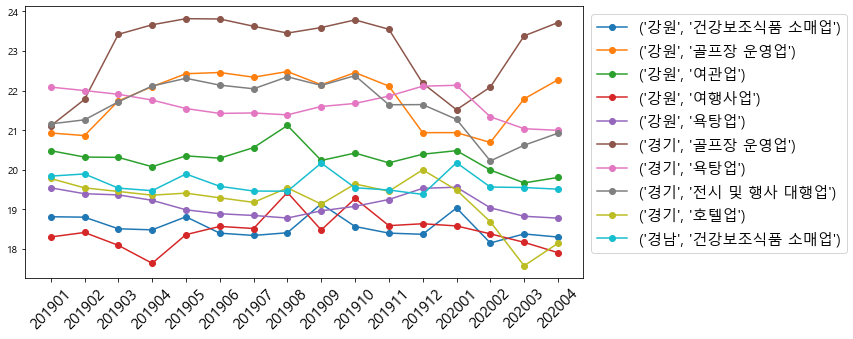

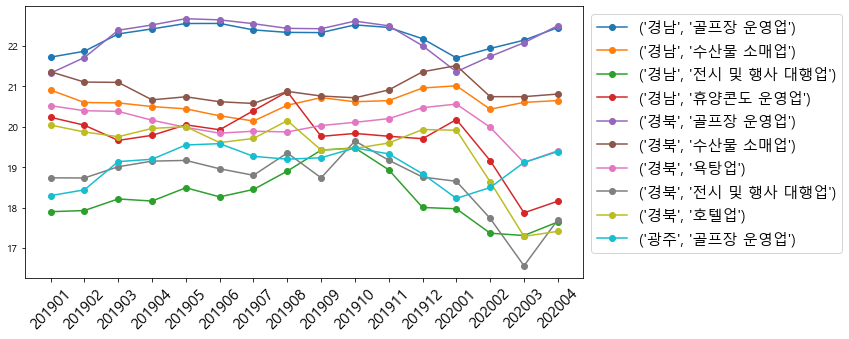

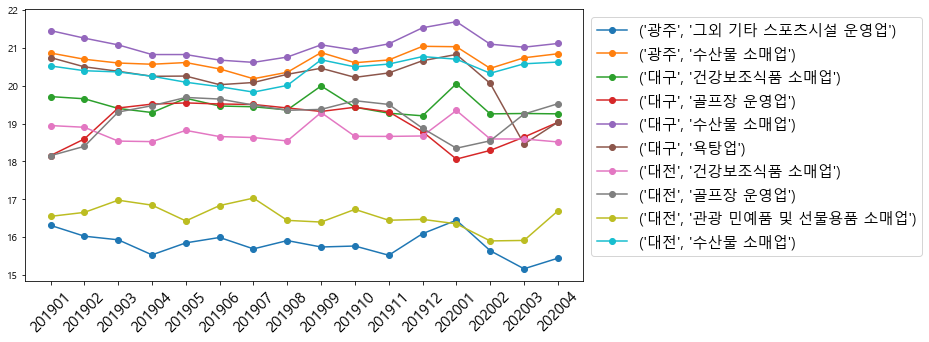

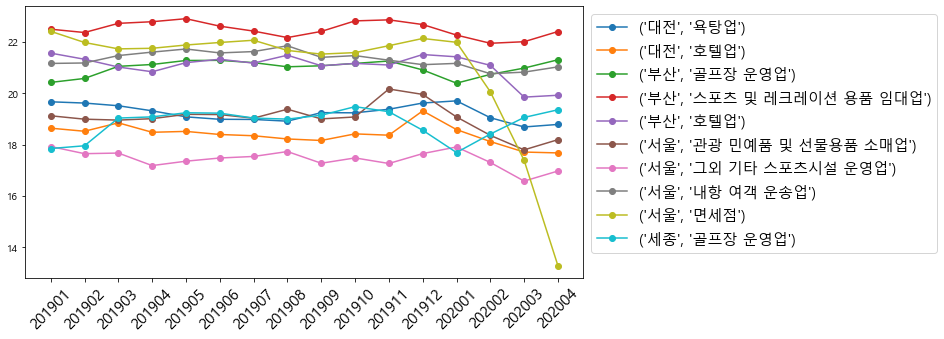

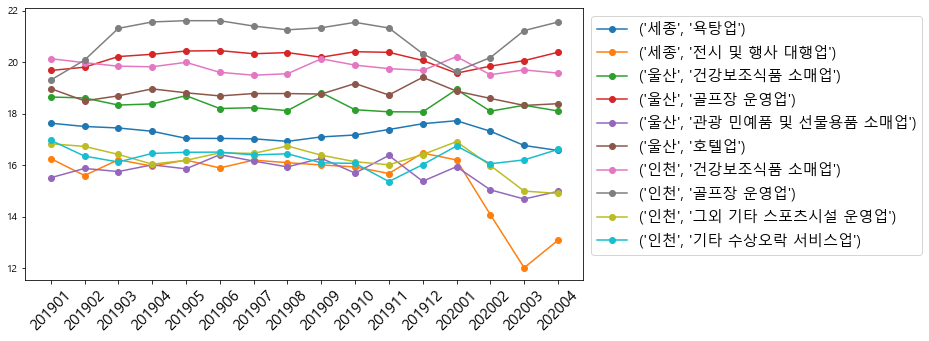

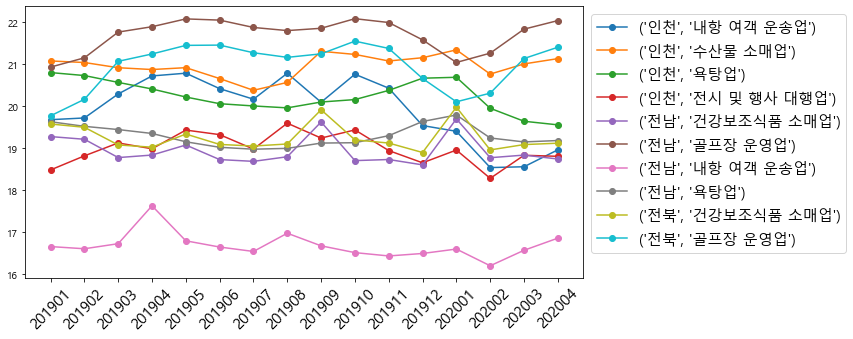

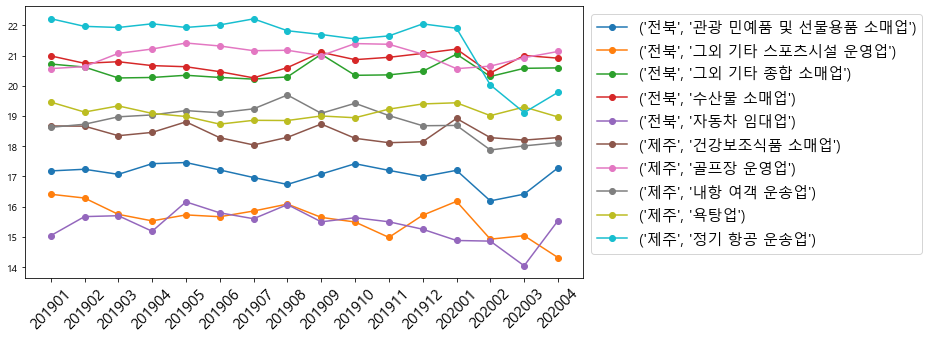

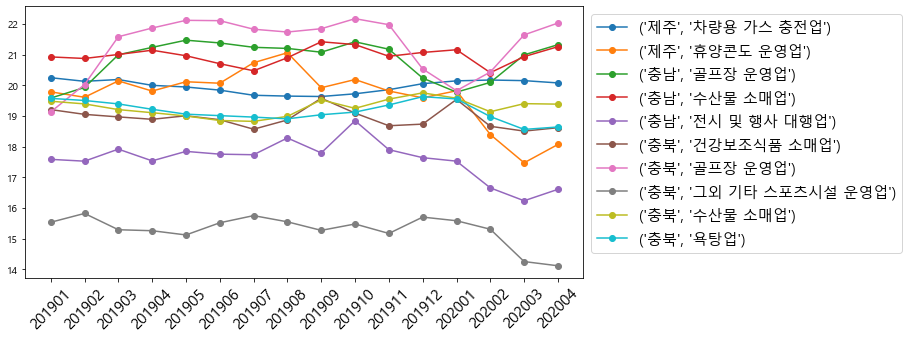

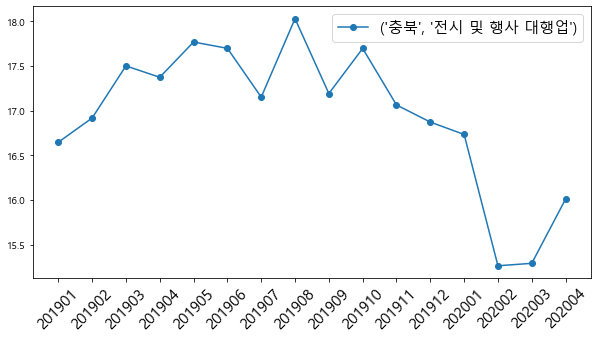

In [12]:
# 변동성이 작으면서 계절성을 갖는 그룹
# std > std_th
# p < p_th
# 계절성
plot_multi_group(group_dic[2])

## group_3

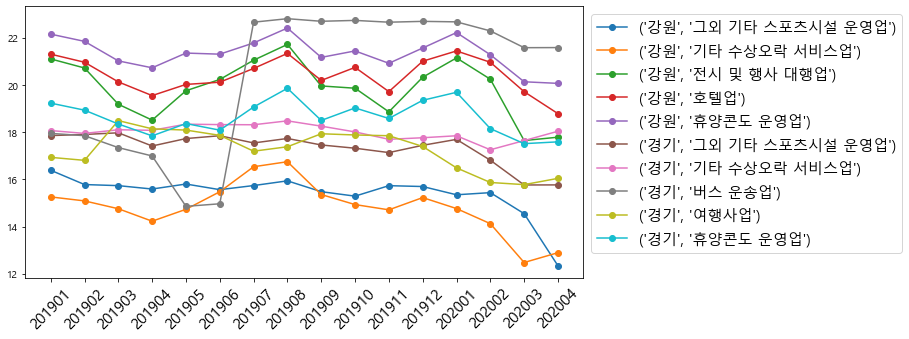

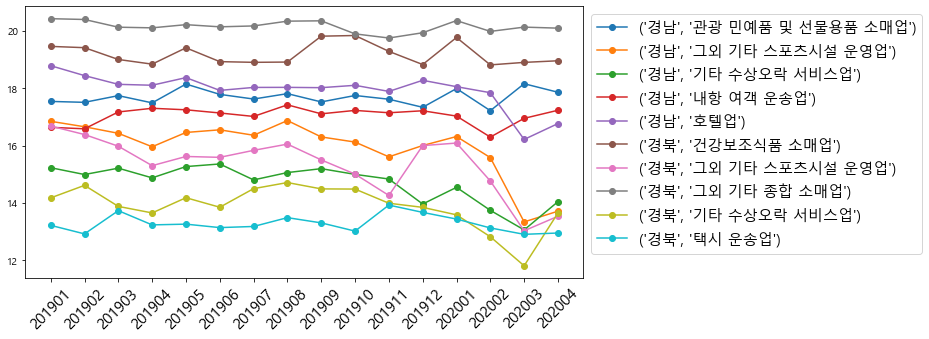

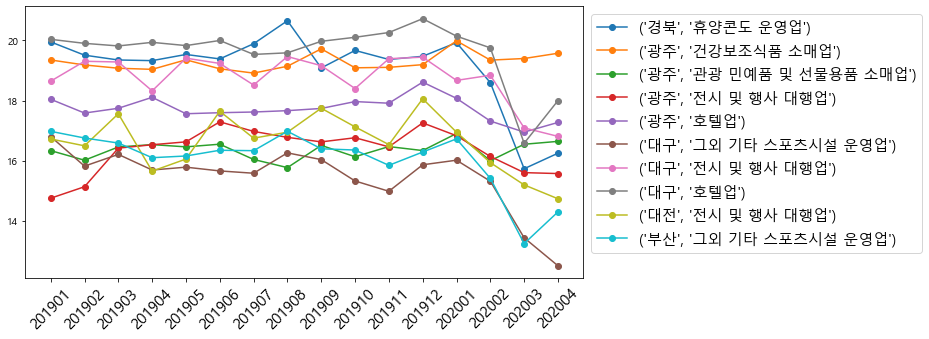

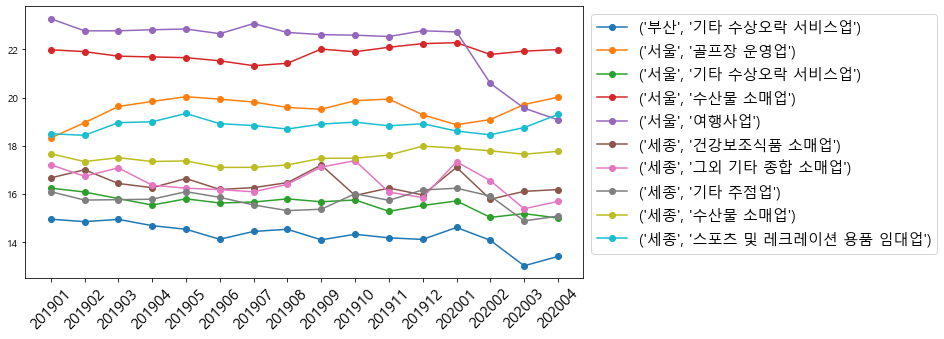

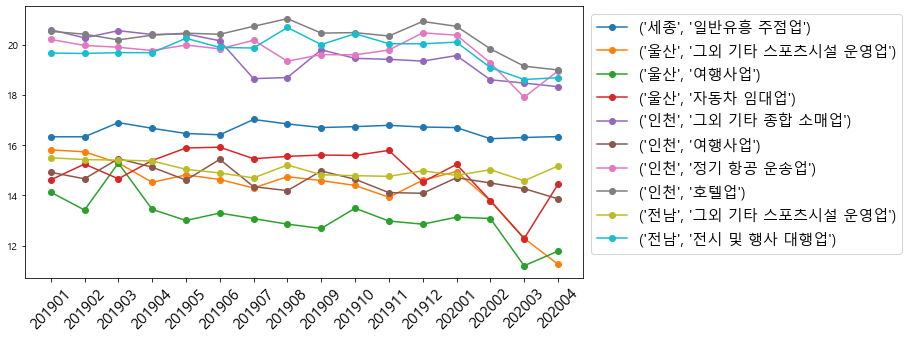

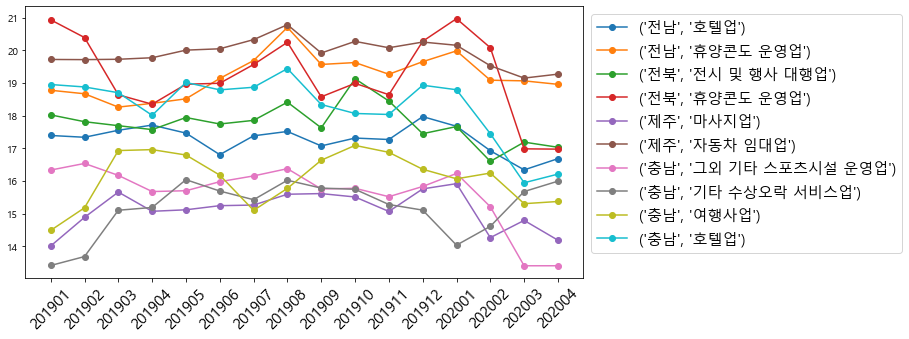

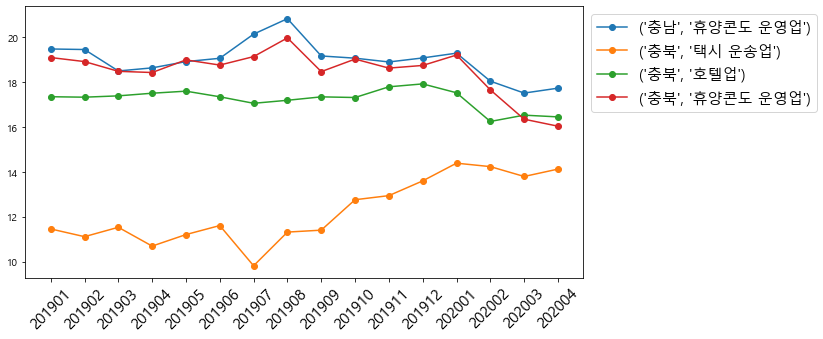

In [13]:
# 변동성이 작으면서 불규칙한 그룹
# std > std_th
# p < p_th
# 불규칙

plot_multi_group(group_dic[3])

## group_4

## std_over_0p3, p_over_0p5

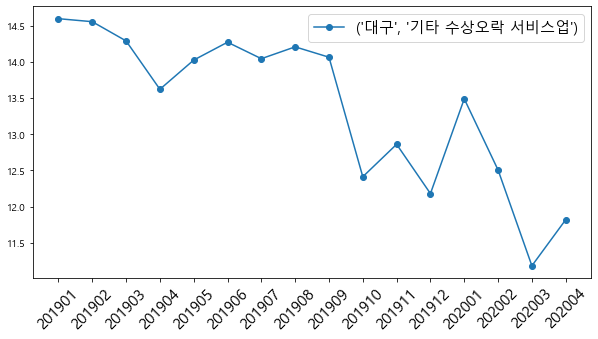

In [14]:
# 변동성이 크면서 선형성을 갖는 그룹
# std > std_th
# p >= p_th
# 선형성
plot_multi_group(group_dic[4])

## group_5

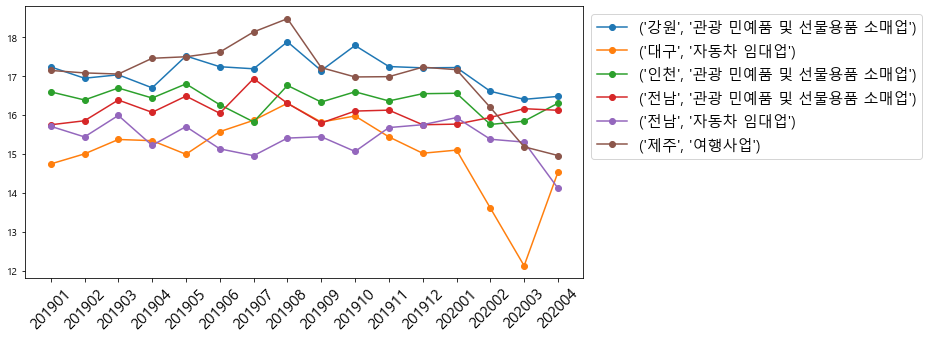

In [15]:
# 변동성이 크면서 계절성을 갖는 그룹
# std > std_th
# p >= p_th
# 계절성
plot_multi_group(group_dic[5])

## group_6

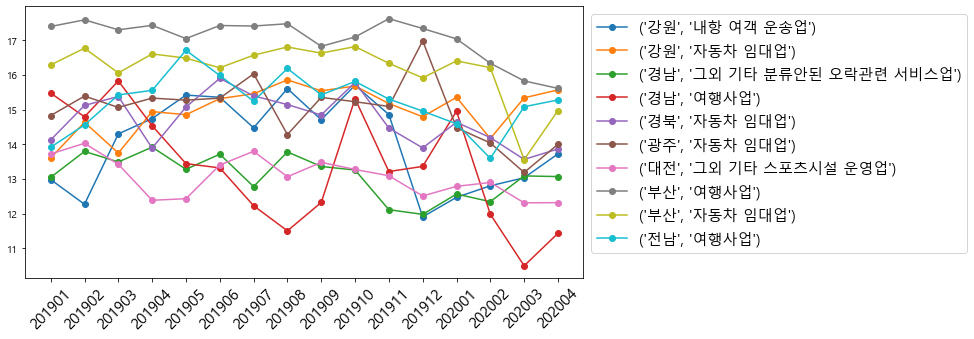

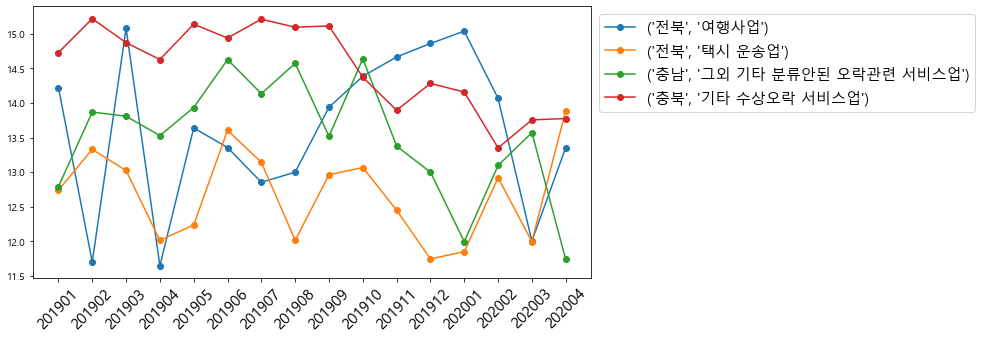

In [16]:
# 변동성이 크면서 불규칙한 그룹
# std > std_th
# p >= p_th
#불규칙
plot_multi_group(group_dic[6])

## group_7

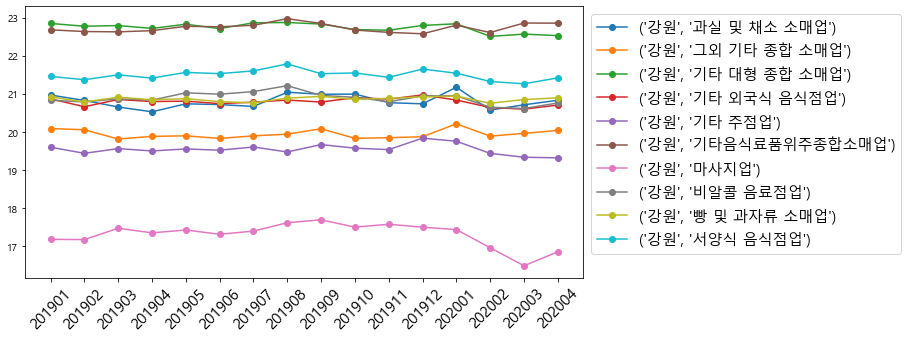

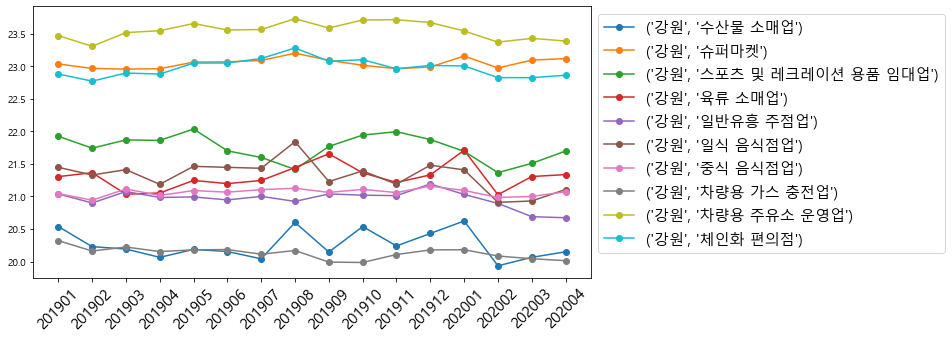

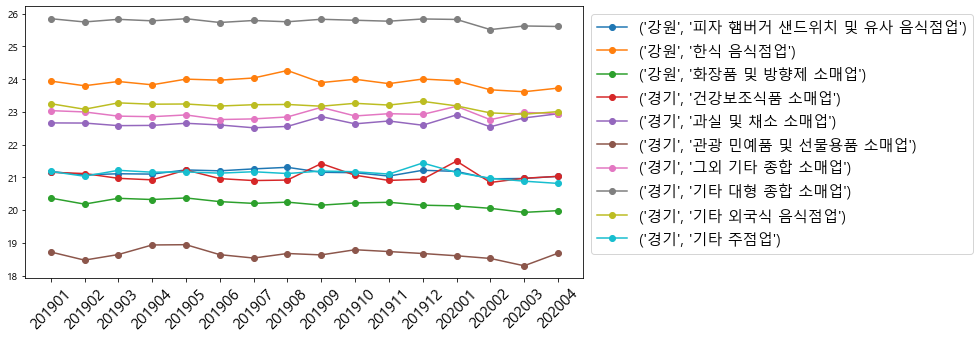

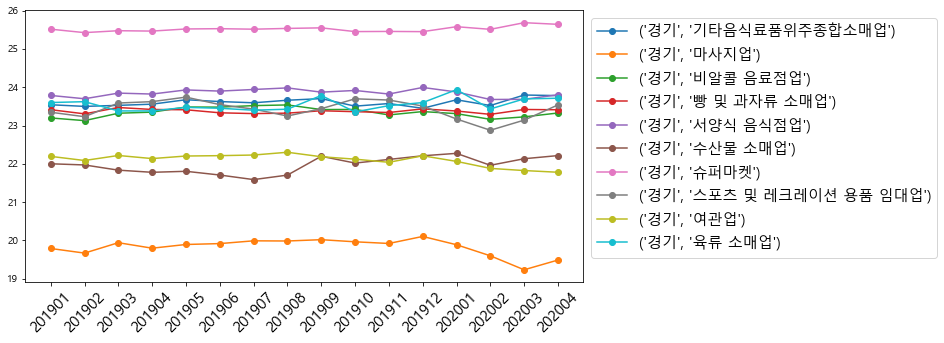

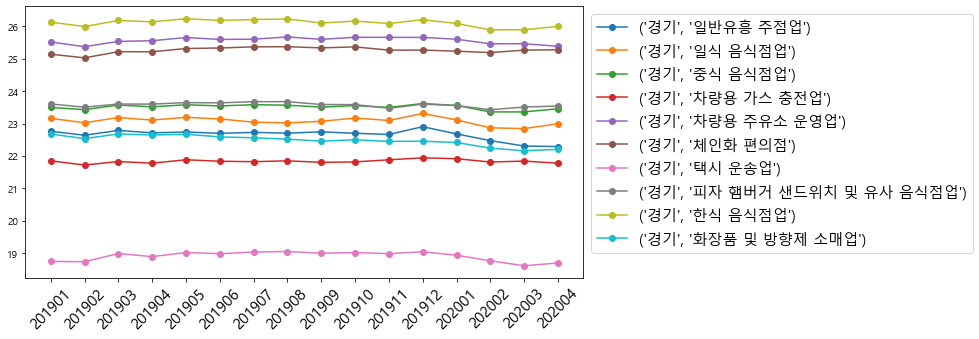

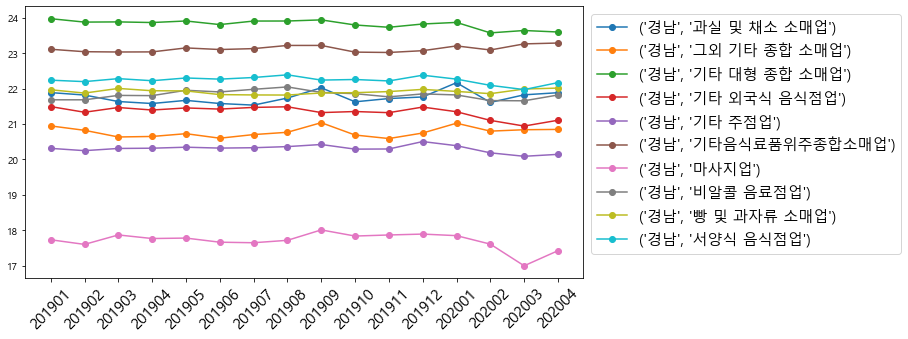

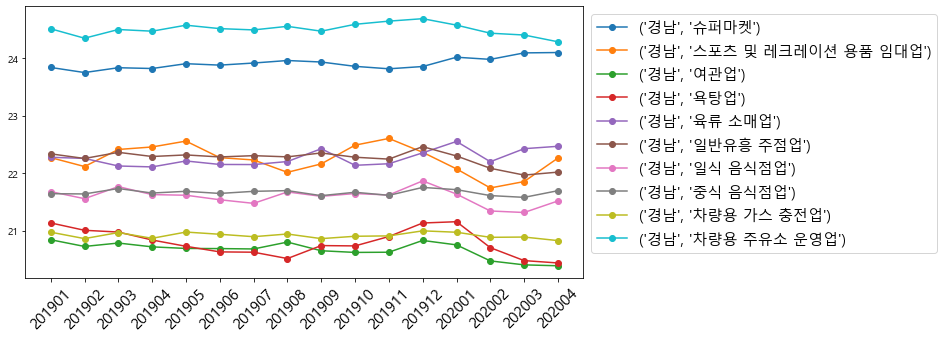

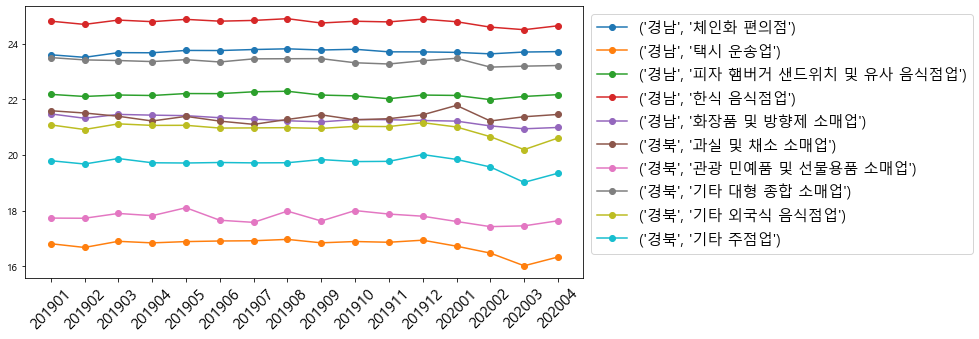

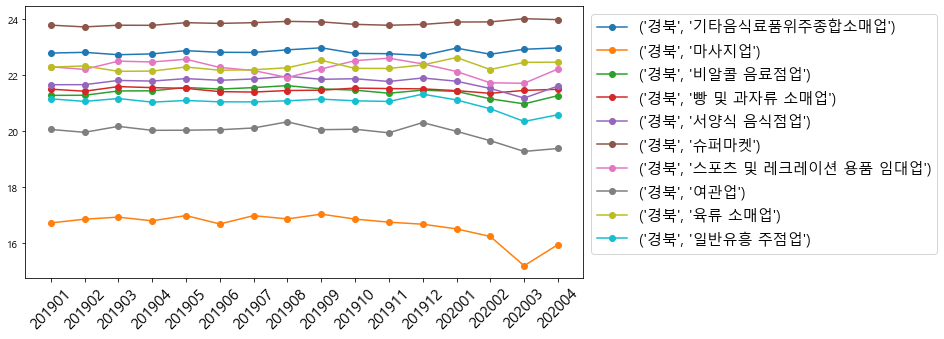

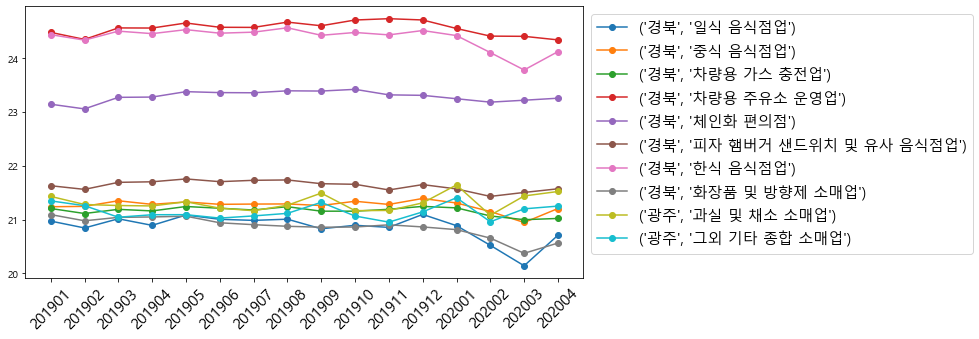

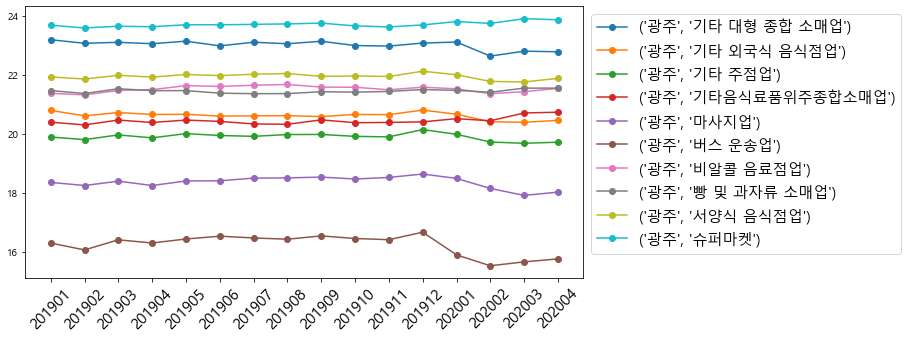

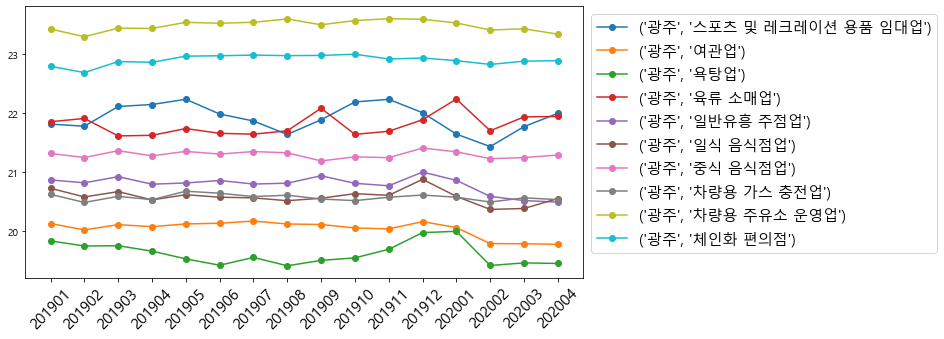

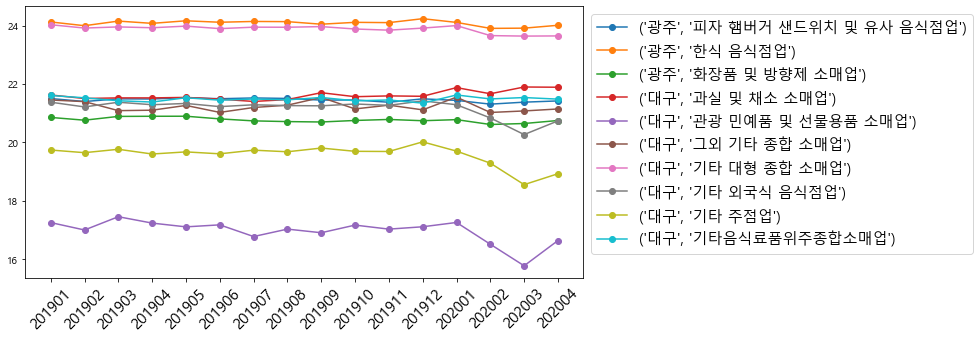

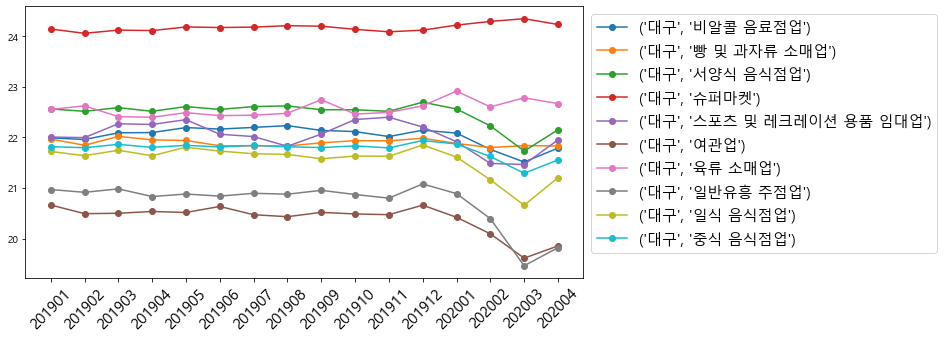

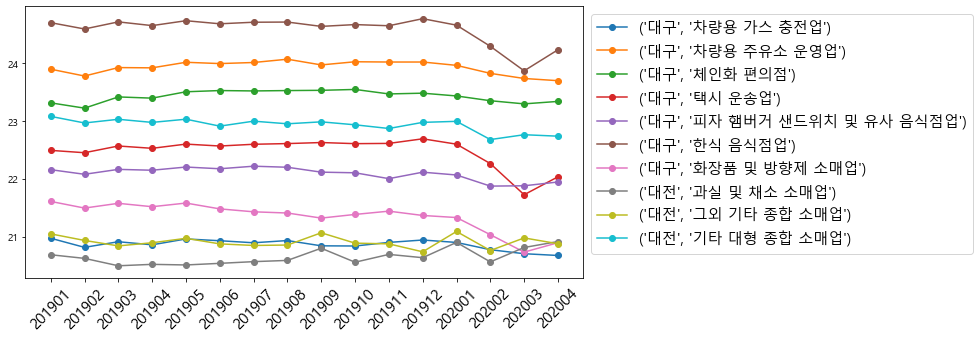

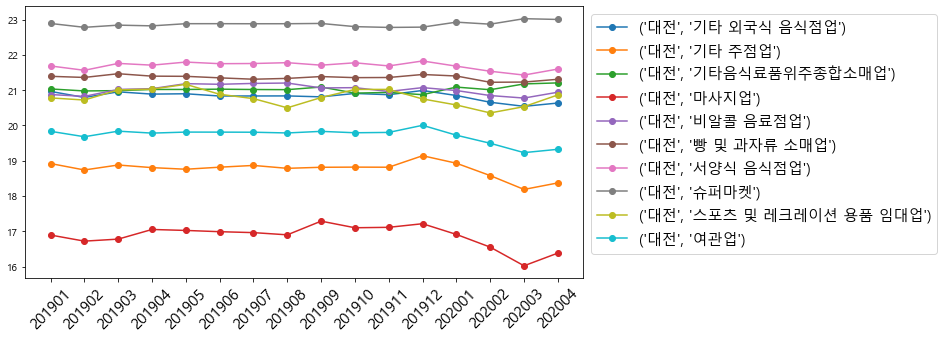

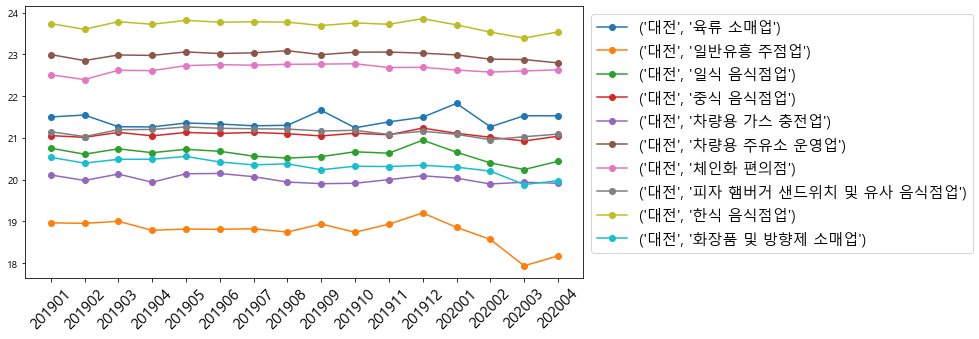

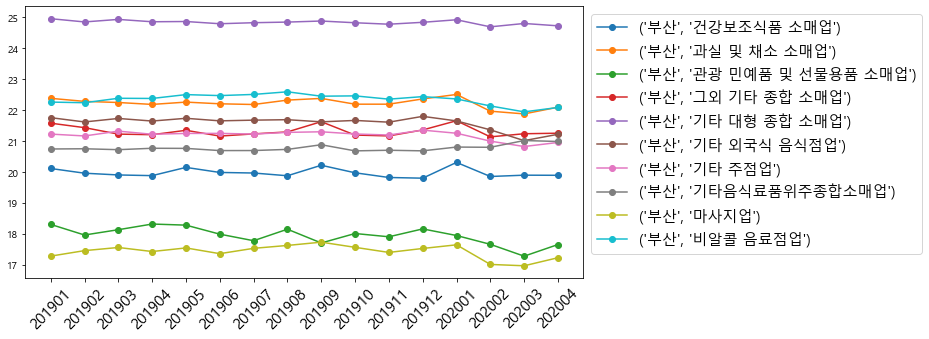

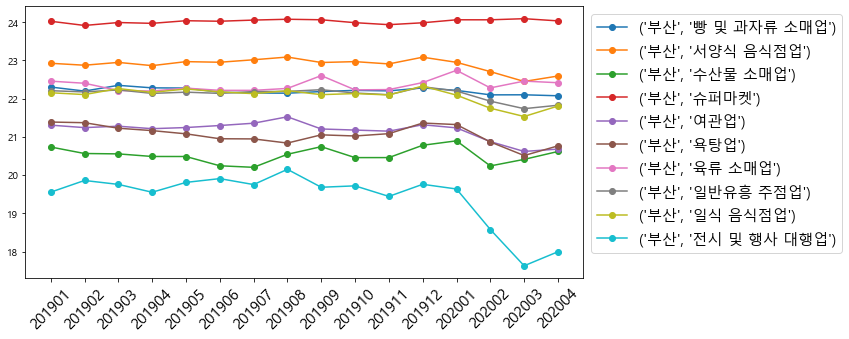

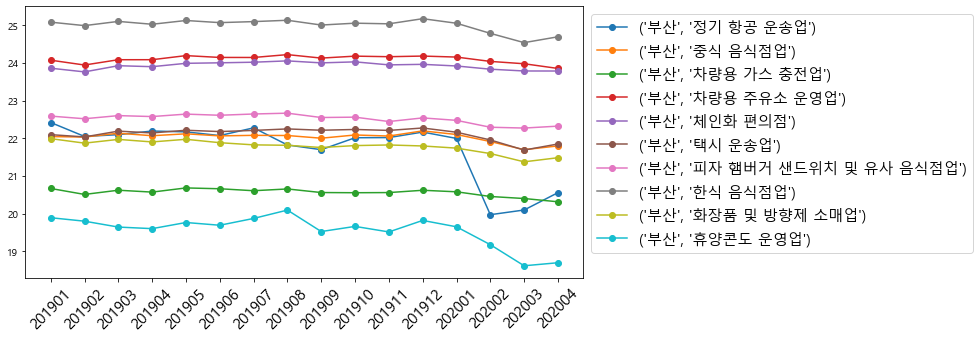

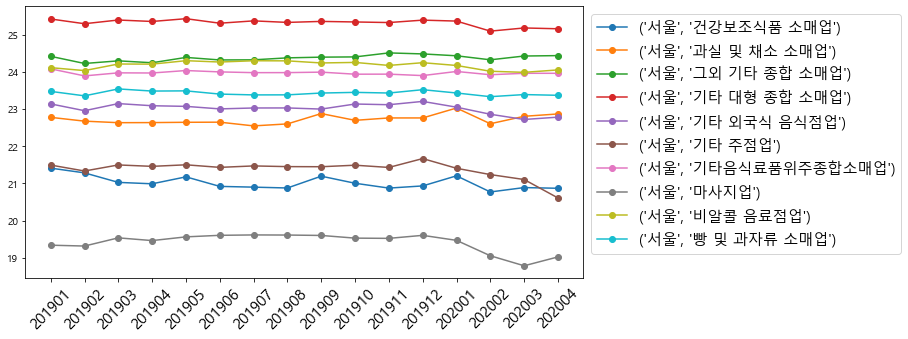

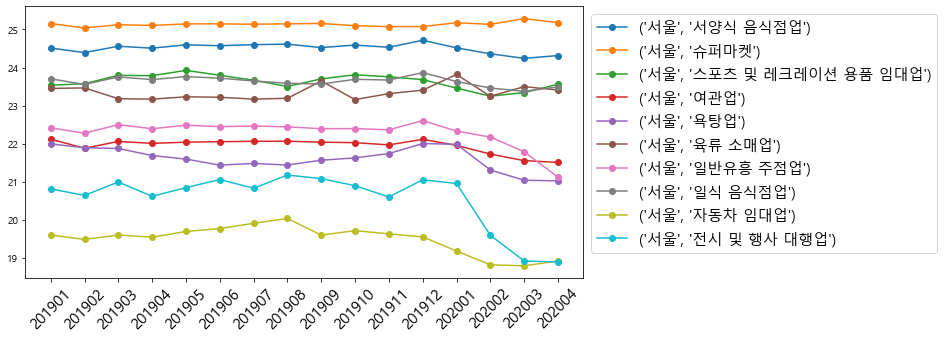

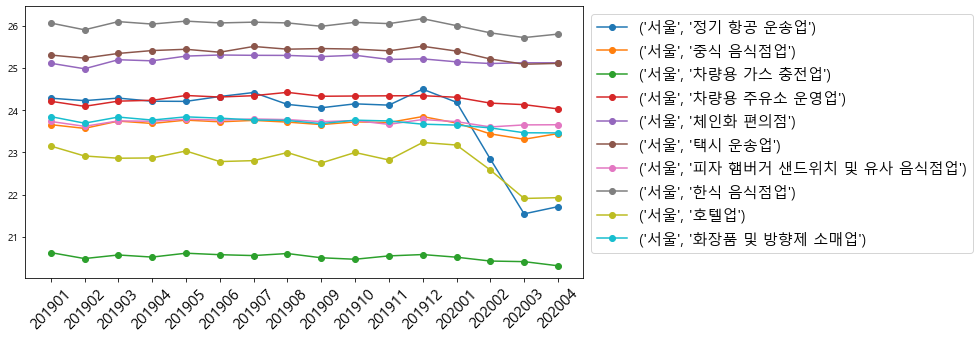

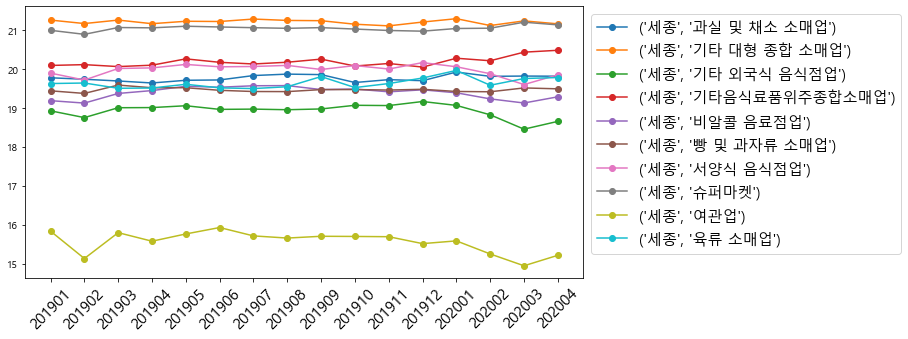

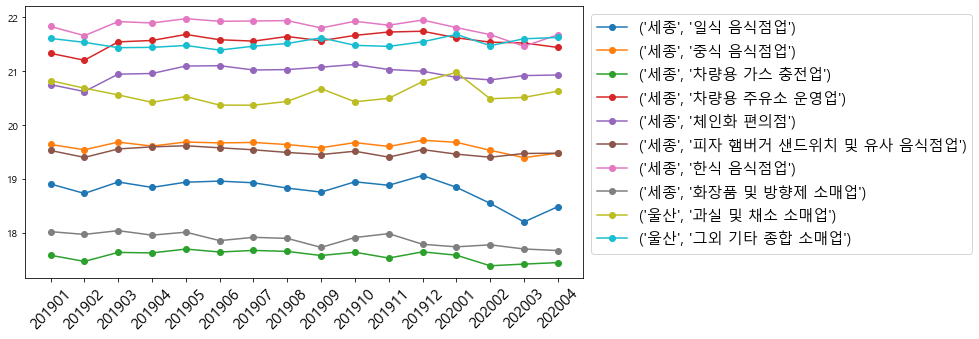

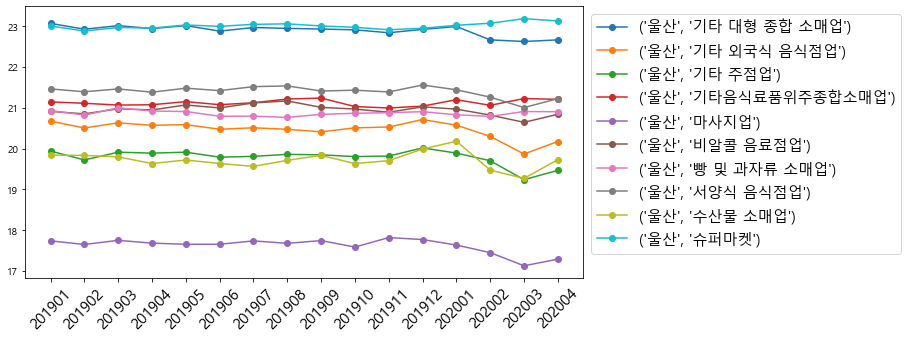

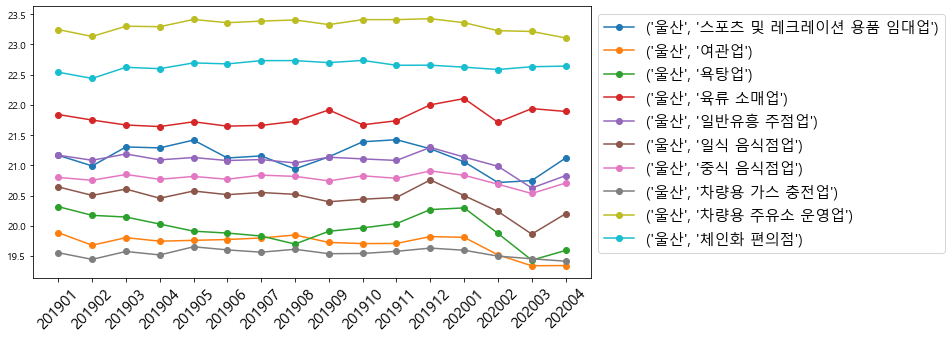

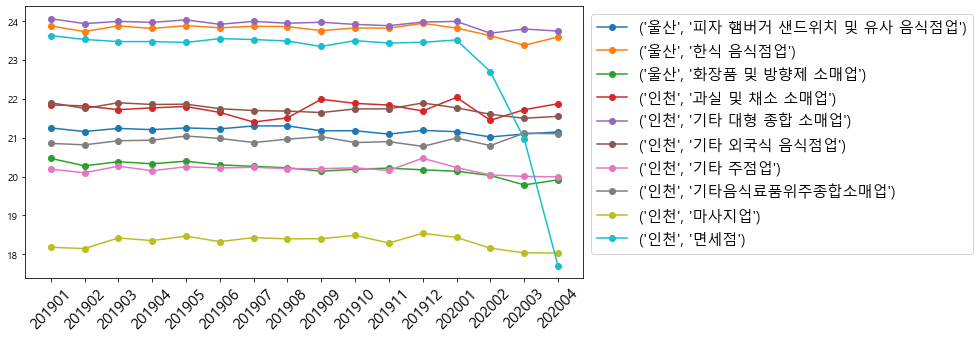

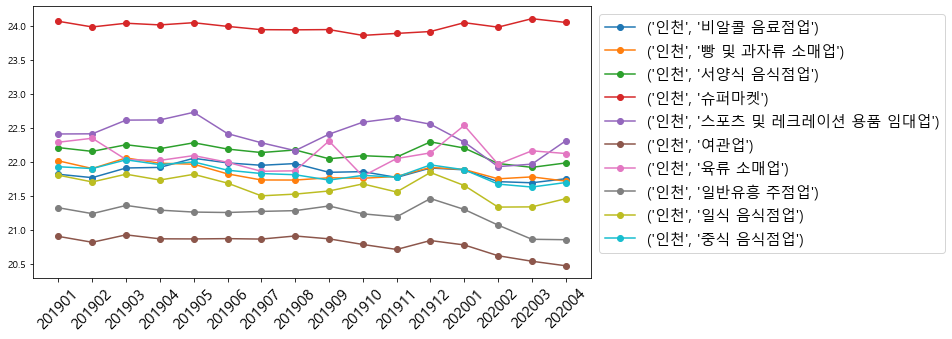

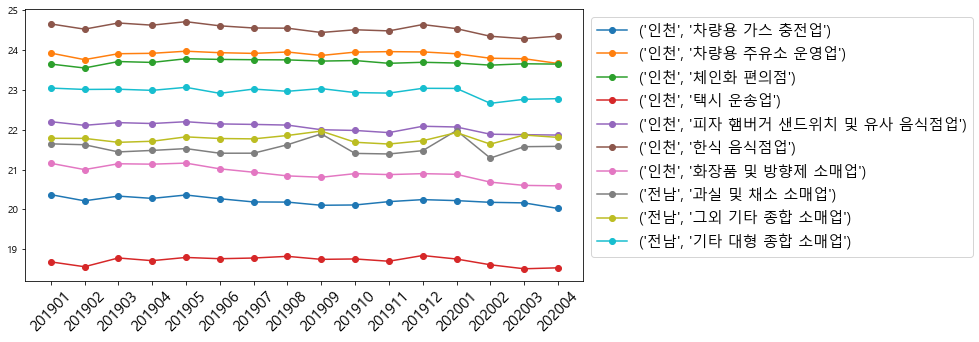

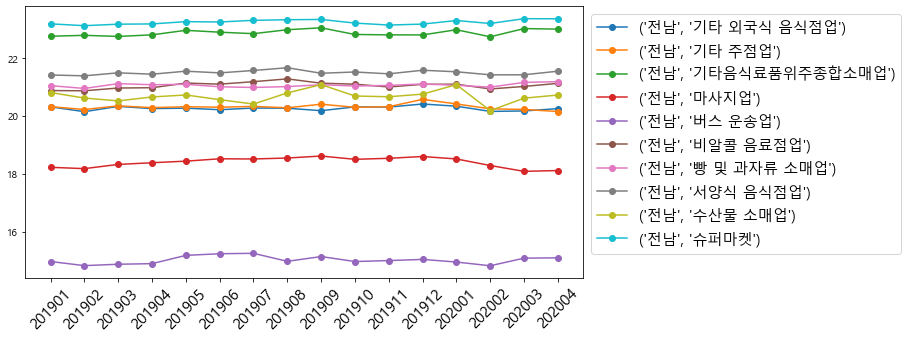

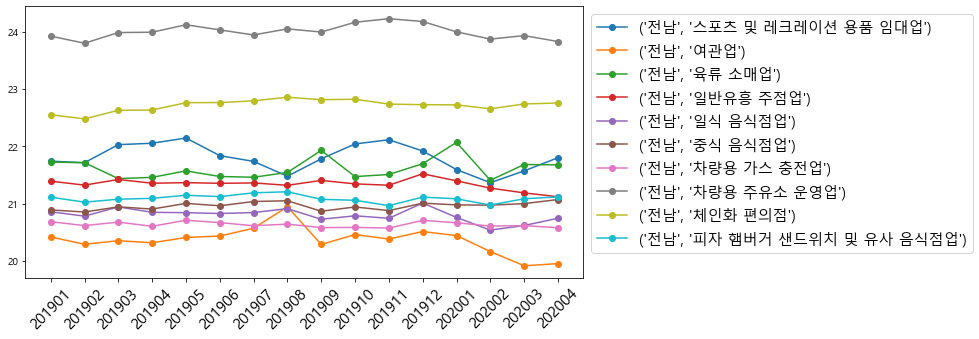

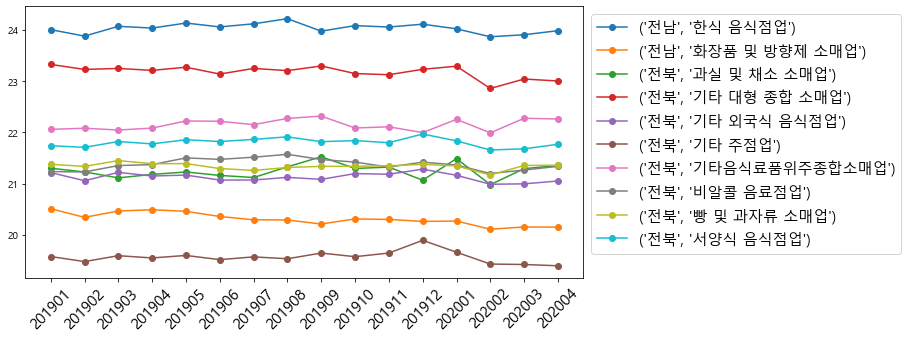

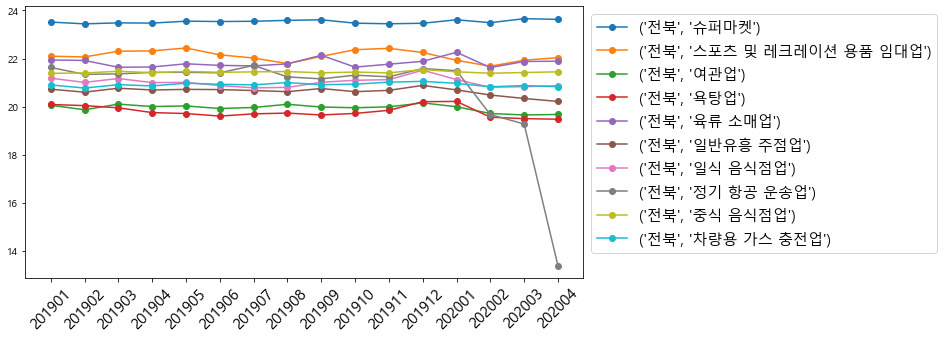

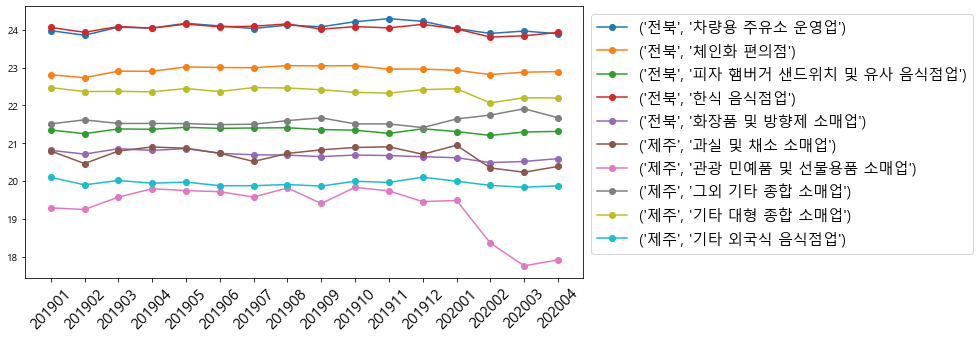

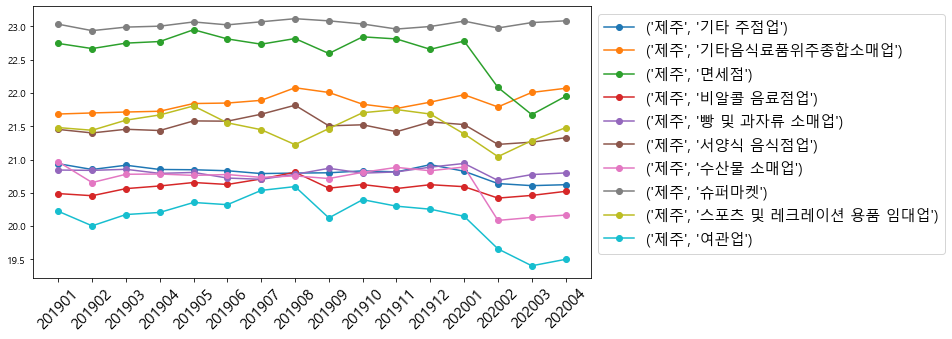

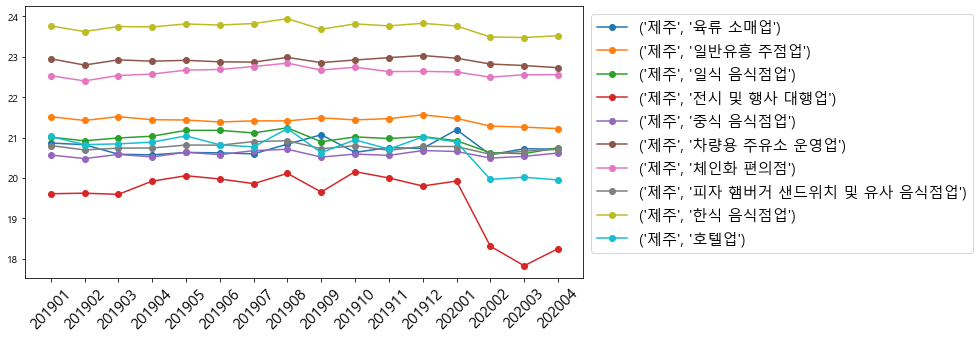

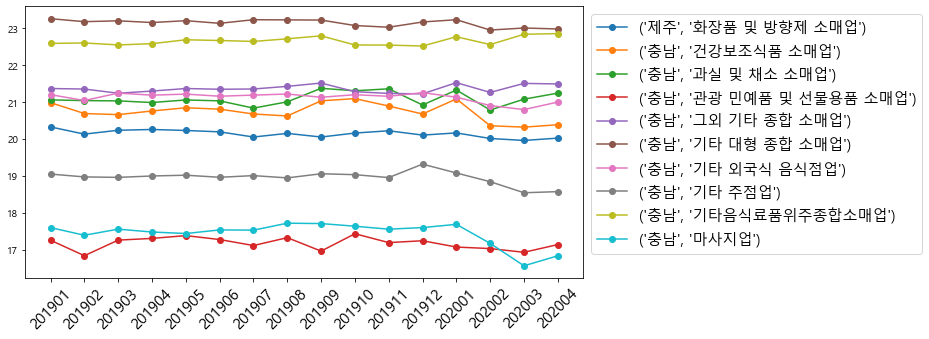

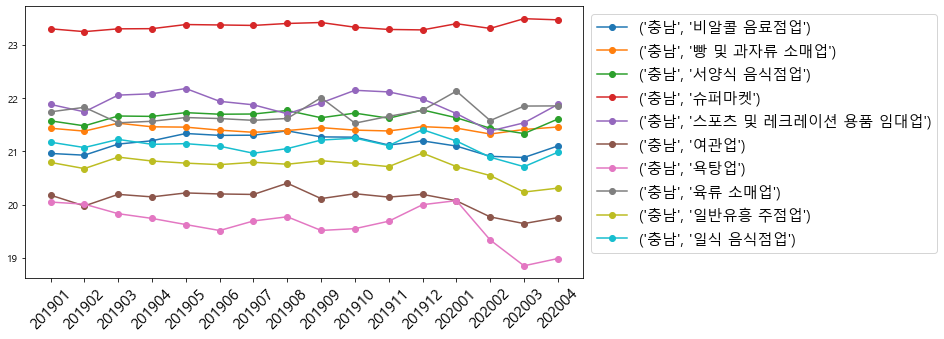

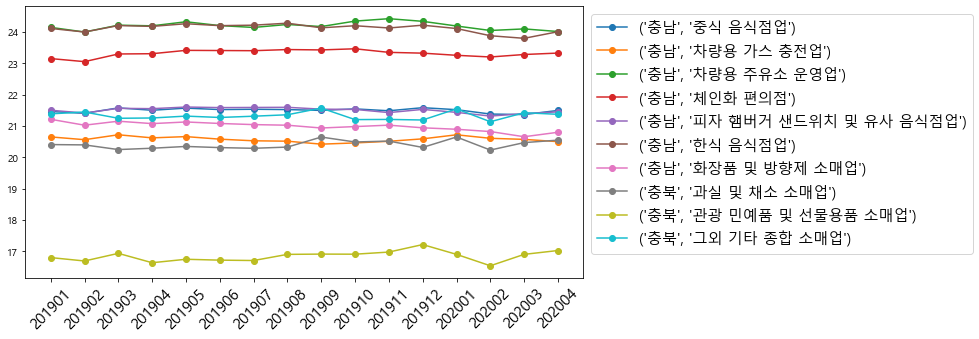

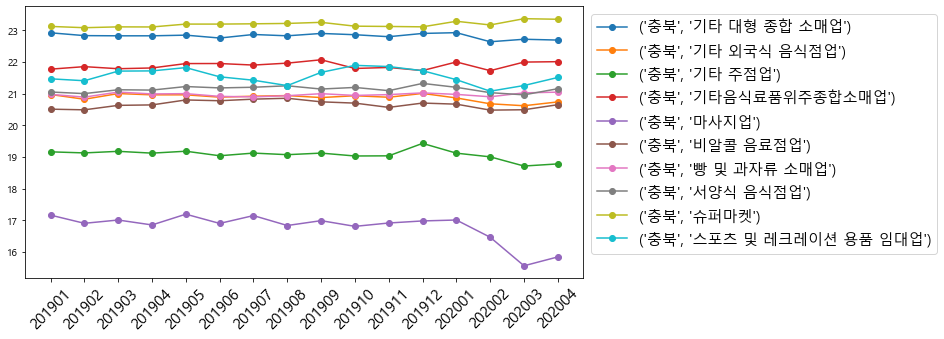

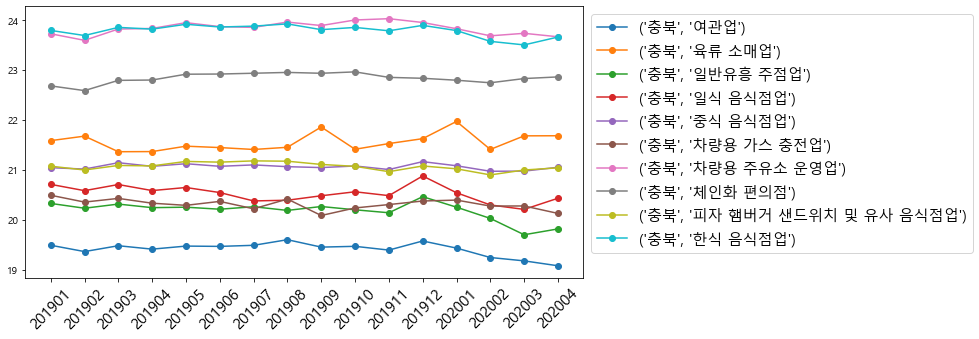

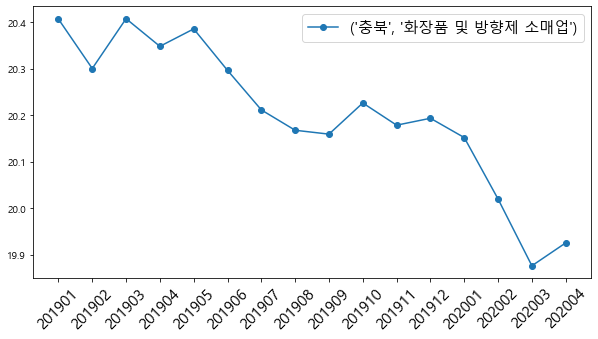

In [17]:
# 평균과 비슷한 그룹
# std <= std_th
plot_multi_group(group_dic[7])# 20개만 plot

## group_8

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log


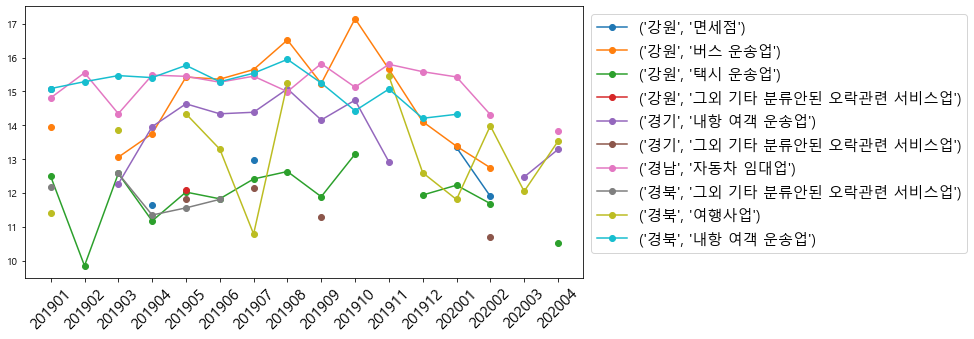

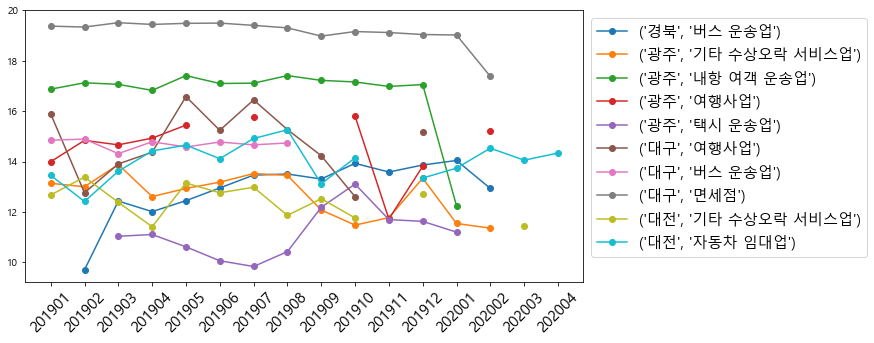

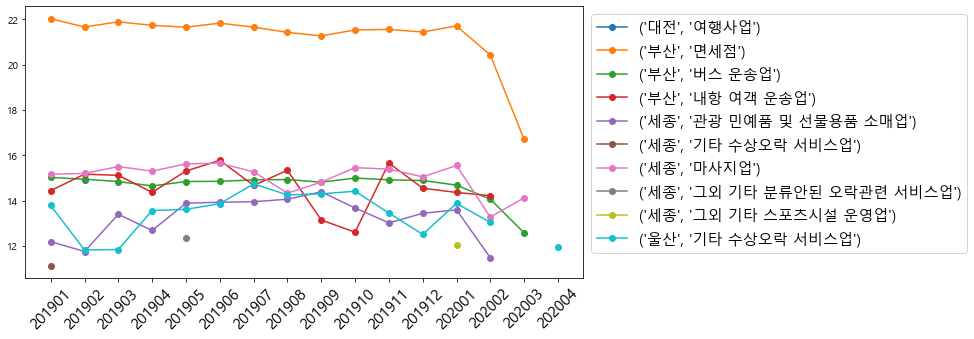

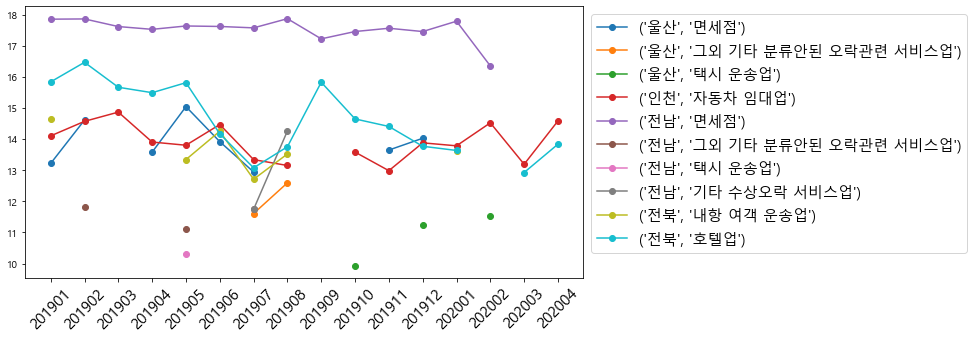

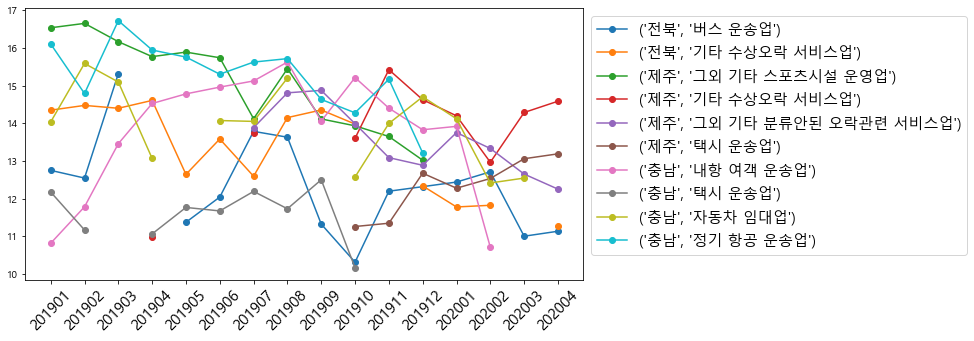

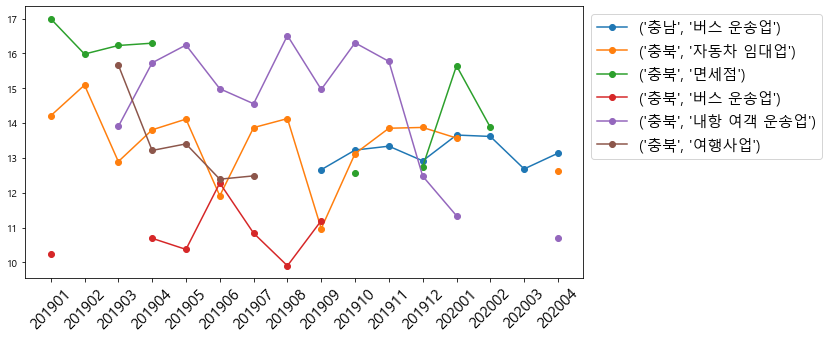

In [18]:
# 월별 데이터가 완전하지 않은 그룹
plot_multi_group(group_dic[8])

In [19]:
total

650

## Make non_cov_7month, cov_ratio

In [20]:
group_city_clss['non_cov_7'] = 0
group_city_clss['cov_ratio'] = 0
group_city_clss

sido_clss_rows_under  total_rows  \
CARD_SIDO_NM STD_CLSS_NM                                               
강원           건강보조식품 소매업                              449        1550   
             골프장 운영업                                9417       34099   
             과실 및 채소 소매업                           10402       28717   
             관광 민예품 및 선물용품 소매업                      2614        4565   
             그외 기타 분류안된 오락관련 서비스업                      2           2   
...                                                  ...         ...   
충북           피자 햄버거 샌드위치 및 유사 음식점업                 12386       37711   
             한식 음식점업                               45582      215298   
             호텔업                                     649        1335   
             화장품 및 방향제 소매업                          1482        7866   
             휴양콘도 운영업                               2494        5330   

                                           p  std_error   diff_per      rmse  \
CARD_SIDO_NM STD_CLSS_NM                                                       
강원           건강보조식품 소매업             0.289677   0.237975   2.560306  0.229872   
             골프장 운영업                0.276166   0.614788   2.577622  0.228864   
             과실 및 채소 소매업            0.362224   0.155196  -1.000000 -1.000000   
             관광 민예품 및 선물용품 소매업      0.572618   0.318397   3.637204  0.233183   
             그외 기타 분류안된 오락관련 서비스업   1.000000  -1.000000  -1.000000 -1.000000   
...                                      ...        ...        ...       ...   
충북           피자 햄버거 샌드위치 및 유사 음식점업  0.328445   0.065237  -1.000000 -1.000000   
             한식 음식점업                0.211716   0.062572  -1.000000 -1.000000   
             호텔업                    0.486142   0.232293  48.834009  0.144811   
             화장품 및 방향제 소매업          0.188406   0.091612  -1.000000 -1.000000   
             휴양콘도 운영업               0.467917   0.404723   3.952846  0.311591   

                                     r2_rate  non_cov_7  cov_ratio  
CARD_SIDO_NM STD_CLSS_NM                                            
강원           건강보조식품 소매업             0.000811          0          0  
             골프장 운영업                0.006120          0          0  
             과실 및 채소 소매업           -1.000000          0          0  
             관광 민예품 및 선물용품 소매업      0.123572          0          0  
             그외 기타 분류안된 오락관련 서비스업  -1.000000          0          0  
...                                      ...        ...        ...  
충북           피자 햄버거 샌드위치 및 유사 음식점업 -1.000000          0          0  
             한식 음식점업               -1.000000          0          0  
             호텔업                    0.161403          0          0  
             화장품 및 방향제 소매업         -1.000000          0          0  
             휴양콘도 운영업               0.014654          0          0  

[650 rows x 9 columns]